Load data

In [187]:
import xarray as xr
from datetime import datetime
from dateutil.relativedelta import relativedelta

# Path to the netCDF files
def generate_spei_file_name(begin: datetime, end: datetime, directory: str):
    spei_file_paths = []
    current_date = begin
    while current_date <= end:
        spei_file_paths.append(
            f'{directory}/spei_{current_date.strftime("%Y%m")}.nc')
        current_date = current_date + relativedelta(months=1)
    return spei_file_paths


begin = datetime(2000, 1, 1)
end = datetime(2020, 12, 1)
spei_file_paths = generate_spei_file_name(begin, end, '/media/jtrvz/1tb/drought_data/spei/spei_db')

In [188]:
from methods.method1.spei_calc_multi import read_nc_files
# Load the precipitation and temperature data
spei_ds = read_nc_files(spei_file_paths)

In [189]:
print(spei_ds.dtypes)

Frozen({'crs': dtype('int32'), 'spei': dtype('float32')})


In [190]:
spei_ds

<xarray.Dataset> Size: 261MB
Dimensions:  (time: 252, lon: 720, lat: 360)
Coordinates:
  * time     (time) datetime64[ns] 2kB 2000-01-16 2000-02-15 ... 2020-12-16
  * lon      (lon) float64 6kB -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * lat      (lat) float64 3kB -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
Data variables:
    crs      (time) int32 1kB 1 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1
    spei     (time, lat, lon) float32 261MB dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
Attributes: (12/18)
    CDI:          Climate Data Interface version 2.0.4 (https://mpimet.mpg.de...
    Conventions:  CF-1.8
    source:       http://sac.csic.es/spei
    institution:  Consejo Superior de Investigaciones Científicas, CSIC
    title:        Global 1-month SPEI, z-values, 0.5 degree
    version:      2.9
    ...           ...
    date:         Wed Jun 21 14:20:48 2023
    reference:    Beguería S., Vicente-Serrano S., Reig F., Latorre B. (2014)...
    reference2:   Vicente-Serrano S.M., Beguería S., López-Moreno J.I. (2010)...
    reference3:   Beguería S., Vicente-Serrano S., Angulo-Martínez M. (2010) ...
    history:      Fri Apr 26 15:09:28 2024: cdo splityearmon spei_v2-9_190101...
    CDO:          Climate Data Operators version 2.0.4 (https://mpimet.mpg.de...

Data Preprocessing

In [192]:
from methods.method1.spei_calc_multi import spatial_subset
# Spatial subset for Germany (Europe)
lat_bounds = [47.0, 55.0]
lon_bounds = [5.5, 15.0]

In [193]:
# Extract the necessary variables, adjust names as per your dataset
# Rearrange the dimensions of the precipitation xarray.DataArray
spei_ds = spatial_subset(spei_ds, lat_bounds, lon_bounds)
spei_ds

<xarray.Dataset> Size: 310kB
Dimensions:  (time: 252, lon: 19, lat: 16)
Coordinates:
  * time     (time) datetime64[ns] 2kB 2000-01-16 2000-02-15 ... 2020-12-16
  * lon      (lon) float64 152B 5.75 6.25 6.75 7.25 ... 13.25 13.75 14.25 14.75
  * lat      (lat) float64 128B 47.25 47.75 48.25 48.75 ... 53.75 54.25 54.75
Data variables:
    crs      (time) int32 1kB 1 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1
    spei     (time, lat, lon) float32 306kB dask.array<chunksize=(1, 16, 19), meta=np.ndarray>
Attributes: (12/18)
    CDI:          Climate Data Interface version 2.0.4 (https://mpimet.mpg.de...
    Conventions:  CF-1.8
    source:       http://sac.csic.es/spei
    institution:  Consejo Superior de Investigaciones Científicas, CSIC
    title:        Global 1-month SPEI, z-values, 0.5 degree
    version:      2.9
    ...           ...
    date:         Wed Jun 21 14:20:48 2023
    reference:    Beguería S., Vicente-Serrano S., Reig F., Latorre B. (2014)...
    reference2:   Vicente-Serrano S.M., Beguería S., López-Moreno J.I. (2010)...
    reference3:   Beguería S., Vicente-Serrano S., Angulo-Martínez M. (2010) ...
    history:      Fri Apr 26 15:09:28 2024: cdo splityearmon spei_v2-9_190101...
    CDO:          Climate Data Operators version 2.0.4 (https://mpimet.mpg.de...

Prepare Data for ML

In [194]:
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

# Convert DataArrays to DataFrame
spei_df = spei_ds.to_dataframe()

In [195]:
spei_df

crs      spei
time       lon   lat                 
2000-01-16 5.75  47.25    1 -1.233108
                 47.75    1 -1.087101
                 48.25    1 -1.008898
                 48.75    1 -1.035698
                 49.25    1 -1.169314
...                     ...       ...
2020-12-16 14.75 52.75    1 -1.440509
                 53.25    1 -1.191428
                 53.75    1 -1.048129
                 54.25    1 -0.791074
                 54.75    1       NaN

[76608 rows x 2 columns]

In [196]:
# Reset index to turn the multi-index into columns
spei_df.reset_index(inplace=True)

In [197]:
spei_df

,time,lon,lat,crs,spei
0,2000-01-16,5.75,47.25,1,-1.233108
1,2000-01-16,5.75,47.75,1,-1.087101
2,2000-01-16,5.75,48.25,1,-1.008898
3,2000-01-16,5.75,48.75,1,-1.035698
4,2000-01-16,5.75,49.25,1,-1.169314
...,...,...,...,...,...
76603,2020-12-16,14.75,52.75,1,-1.440509
76604,2020-12-16,14.75,53.25,1,-1.191428
76605,2020-12-16,14.75,53.75,1,-1.048129
76606,2020-12-16,14.75,54.25,1,-0.791074


In [198]:
# Create lag features
for lag in range(1, 4):  # Here 3 lags are considered
    spei_df[f'spei_lag_{lag}'] = spei_df['spei'].shift(lag)

In [199]:
spei_df

,time,lon,lat,crs,spei,spei_lag_1,spei_lag_2,spei_lag_3
0,2000-01-16,5.75,47.25,1,-1.233108,NaN,NaN,NaN
1,2000-01-16,5.75,47.75,1,-1.087101,-1.233108,NaN,NaN
2,2000-01-16,5.75,48.25,1,-1.008898,-1.087101,-1.233108,NaN
3,2000-01-16,5.75,48.75,1,-1.035698,-1.008898,-1.087101,-1.233108
4,2000-01-16,5.75,49.25,1,-1.169314,-1.035698,-1.008898,-1.087101
...,...,...,...,...,...,...,...,...
76603,2020-12-16,14.75,52.75,1,-1.440509,-1.561024,-1.564191,-1.492759
76604,2020-12-16,14.75,53.25,1,-1.191428,-1.440509,-1.561024,-1.564191
76605,2020-12-16,14.75,53.75,1,-1.048129,-1.191428,-1.440509,-1.561024
76606,2020-12-16,14.75,54.25,1,-0.791074,-1.048129,-1.191428,-1.440509


In [200]:
# Drop rows with missing values due to lag creation
spei_df.dropna(inplace=True)

In [201]:
spei_df

,time,lon,lat,crs,spei,spei_lag_1,spei_lag_2,spei_lag_3
3,2000-01-16,5.75,48.75,1,-1.035698,-1.008898,-1.087101,-1.233108
4,2000-01-16,5.75,49.25,1,-1.169314,-1.035698,-1.008898,-1.087101
5,2000-01-16,5.75,49.75,1,-0.719492,-1.169314,-1.035698,-1.008898
6,2000-01-16,5.75,50.25,1,-0.859133,-0.719492,-1.169314,-1.035698
7,2000-01-16,5.75,50.75,1,-0.938556,-0.859133,-0.719492,-1.169314
...,...,...,...,...,...,...,...,...
76602,2020-12-16,14.75,52.25,1,-1.561024,-1.564191,-1.492759,-1.540320
76603,2020-12-16,14.75,52.75,1,-1.440509,-1.561024,-1.564191,-1.492759
76604,2020-12-16,14.75,53.25,1,-1.191428,-1.440509,-1.561024,-1.564191
76605,2020-12-16,14.75,53.75,1,-1.048129,-1.191428,-1.440509,-1.561024


In [202]:
# Train/test split
train_end = pd.Timestamp('2010-01-01')
train = spei_df[spei_df['time'] < train_end]
test = spei_df[spei_df['time'] >= train_end]

In [203]:
train

,time,lon,lat,crs,spei,spei_lag_1,spei_lag_2,spei_lag_3
3,2000-01-16,5.75,48.75,1,-1.035698,-1.008898,-1.087101,-1.233108
4,2000-01-16,5.75,49.25,1,-1.169314,-1.035698,-1.008898,-1.087101
5,2000-01-16,5.75,49.75,1,-0.719492,-1.169314,-1.035698,-1.008898
6,2000-01-16,5.75,50.25,1,-0.859133,-0.719492,-1.169314,-1.035698
7,2000-01-16,5.75,50.75,1,-0.938556,-0.859133,-0.719492,-1.169314
...,...,...,...,...,...,...,...,...
36474,2009-12-16,14.75,52.25,1,0.826948,1.452578,1.551798,1.558362
36475,2009-12-16,14.75,52.75,1,0.429331,0.826948,1.452578,1.551798
36476,2009-12-16,14.75,53.25,1,0.244346,0.429331,0.826948,1.452578
36477,2009-12-16,14.75,53.75,1,0.017093,0.244346,0.429331,0.826948


In [204]:
test

,time,lon,lat,crs,spei,spei_lag_1,spei_lag_2,spei_lag_3
36483,2010-01-16,5.75,48.75,1,-0.965412,-0.754446,-0.798004,-0.917010
36484,2010-01-16,5.75,49.25,1,-0.897175,-0.965412,-0.754446,-0.798004
36485,2010-01-16,5.75,49.75,1,-0.912586,-0.897175,-0.965412,-0.754446
36486,2010-01-16,5.75,50.25,1,-0.984667,-0.912586,-0.897175,-0.965412
36487,2010-01-16,5.75,50.75,1,-0.922209,-0.984667,-0.912586,-0.897175
...,...,...,...,...,...,...,...,...
76602,2020-12-16,14.75,52.25,1,-1.561024,-1.564191,-1.492759,-1.540320
76603,2020-12-16,14.75,52.75,1,-1.440509,-1.561024,-1.564191,-1.492759
76604,2020-12-16,14.75,53.25,1,-1.191428,-1.440509,-1.561024,-1.564191
76605,2020-12-16,14.75,53.75,1,-1.048129,-1.191428,-1.440509,-1.561024


In [205]:
# Feature and target columns
X_train = train[['lat', 'lon','spei_lag_1', 'spei_lag_2', 'spei_lag_3']]
y_train = train['spei']
X_test = test[['lat', 'lon', 'spei_lag_1', 'spei_lag_2', 'spei_lag_3']]
y_test = test['spei']

In [206]:
X_train.head()

,lat,lon,spei_lag_1,spei_lag_2,spei_lag_3
3,48.75,5.75,-1.008898,-1.087101,-1.233108
4,49.25,5.75,-1.035698,-1.008898,-1.087101
5,49.75,5.75,-1.169314,-1.035698,-1.008898
6,50.25,5.75,-0.719492,-1.169314,-1.035698
7,50.75,5.75,-0.859133,-0.719492,-1.169314


In [207]:
y_train.head()

3   -1.035698
4   -1.169314
5   -0.719492
6   -0.859133
7   -0.938556
Name: spei, dtype: float32

In [208]:
X_test.head()

,lat,lon,spei_lag_1,spei_lag_2,spei_lag_3
36483,48.75,5.75,-0.754446,-0.798004,-0.917010
36484,49.25,5.75,-0.965412,-0.754446,-0.798004
36485,49.75,5.75,-0.897175,-0.965412,-0.754446
36486,50.25,5.75,-0.912586,-0.897175,-0.965412
36487,50.75,5.75,-0.984667,-0.912586,-0.897175


In [209]:
y_test.head()

36483   -0.965412
36484   -0.897175
36485   -0.912586
36486   -0.984667
36487   -0.922209
Name: spei, dtype: float32

In [210]:
# Initialize and fit the Gradient Boosting model
model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
model.fit(X_train, y_train)

GradientBoostingRegressor(random_state=42)

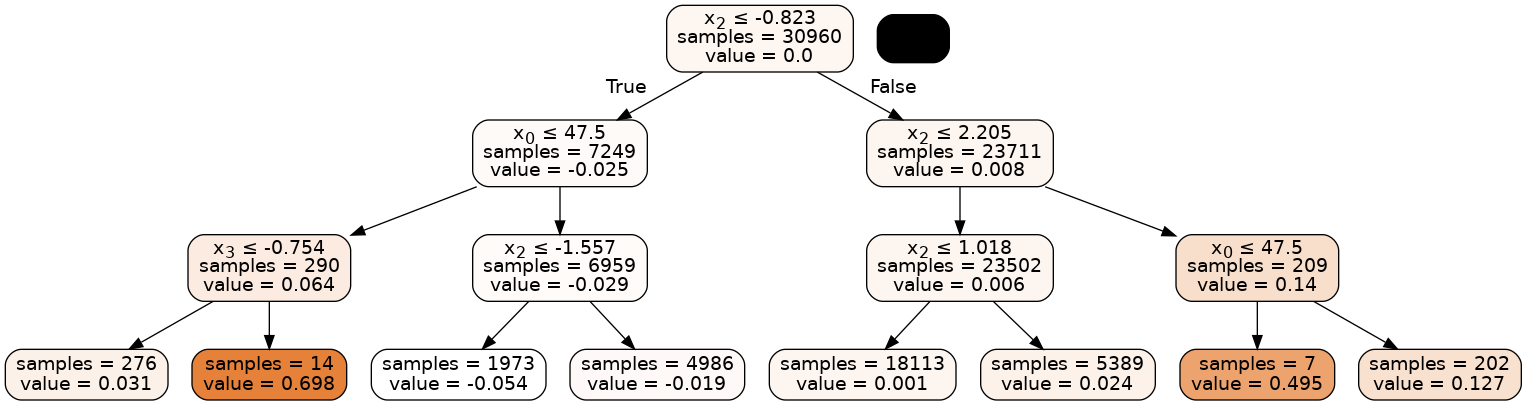

In [211]:
sub_tree_42 = model.estimators_[42, 0]

from pydotplus import graph_from_dot_data
from IPython.display import Image
from sklearn.tree import export_graphviz

dot_data = export_graphviz(
    sub_tree_42,
    out_file=None, filled=True, rounded=True,
    special_characters=True,
    proportion=False, impurity=False, # enable them if you want
)
graph = graph_from_dot_data(dot_data)
png = graph.create_png()
# Save (optional)
from pathlib import Path
Path(f"./out_{begin.strftime('%Y-%m-%d')}_{end.strftime('%Y-%m-%d')}.png").write_bytes(png)
# Display
Image(png)

In [212]:
# Predict and evaluate
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print(f'Test MSE: {mse}')

Test MSE: 0.06875515139642141


## Save model

In [213]:
import joblib
joblib.dump(model, f"model_{begin.strftime('%Y-%m-%d')}_{train_end.strftime('%Y-%m-%d')}.pkl")

['model_2000-01-01_2010-01-01.pkl']

## Load model

In [214]:
# Example previous SPEI values
data = {
    'lat': [48.75],   # example precipitation values
    'lon': [5.75],   # example precipitation values
    'spei_lag_1': [-0.361366],  # SPEI from one month ago
    'spei_lag_2': [-0.388305],  # SPEI from two months ago
    'spei_lag_3': [-0.432840],   # SPEI from three months ago
}
			
# SPEI -0.426906

# Recreate the DataFrame
df_new = pd.DataFrame(data)
print(X_train.columns)
df_new = df_new[X_train.columns]

# Now predict using the updated DataFrame
predictions = model.predict(df_new)

# Output the predictions
print("Predicted SPEI values:", predictions)

Index(['lat', 'lon', 'spei_lag_1', 'spei_lag_2', 'spei_lag_3'], dtype='object')
Predicted SPEI values: [-0.35633107]


## Validate model

In [215]:
def predict_spei(model_path, X_train, lat, lon, spei_lag_1, spei_lag_2, spei_lag_3):
    # Load the trained model
    model = joblib.load(model_path)

    # Create a DataFrame with the input values
    data = {
        'lat': [lat],
        'lon': [lon],
        'spei_lag_1': [spei_lag_1],
        'spei_lag_2': [spei_lag_2],
        'spei_lag_3': [spei_lag_3],
    }
    df = pd.DataFrame(data)
    df = df[X_train.columns]

    # Predict the spei value
    predictions = model.predict(df)

    # Output the prediction
    return predictions[0]

In [216]:
diffs = {}
max_diff = None
max_diff_spei = None
max_diff_spei_predicted = None

min_diff = None
min_diff_spei = None
min_diff_spei_predicted = None

for index, row in spei_df.iterrows():
    time = row['time']
    if time > pd.Timestamp('2015-02-01') and time < pd.Timestamp('2016-03-01'):
        lat = row['lat']
        lon = row['lon']
        spei = row['spei']
        spei_lag_1 = row['spei_lag_1']
        spei_lag_2 = row['spei_lag_2']
        spei_lag_3 = row['spei_lag_3']

        predicted_spei = predict_spei(
            f"model_{begin.strftime('%Y-%m-%d')}_{train_end.strftime('%Y-%m-%d')}.pkl",
            X_train,
            lat, lon, spei_lag_1, spei_lag_2, spei_lag_3)

        diff = abs(spei - predicted_spei)

        if max_diff is None or \
                diff > max_diff:
            max_diff = diff
            max_diff_spei = spei
            max_diff_spei_predicted = predicted_spei

        if min_diff is None or \
                diff < min_diff:
            min_diff = diff
            min_diff_spei = spei
            min_diff_spei_predicted = predicted_spei

        # print(
        #     f'Actual SPEI: {spei}, Predicted SPEI: {predicted_spei}, Difference: {diff}\n')
        diffs[diff] = (spei, predicted_spei)

The closer the percentage is to 100.00%, the better is the prediction.

In [217]:
min_diff_formatted = format(float(min_diff), '.10f')
max_diff_formatted = format(float(max_diff), '.10f')

print(f'Mean difference:')
# Value
total_spei = sum(value[0] for value in diffs.values())
mean_spei = total_spei / len(diffs)
# Percentage
total_ratio = sum((value[1] / value[0]) *
                  100 for value in diffs.values() if value[0] != 0)
average_ratio = total_ratio / len(diffs)
print(f'{mean_spei / len(diffs)} | {average_ratio:.2f}%')
print(f'Max difference:')
print(f'~{max_diff_formatted} | ~{((max_diff_spei_predicted / max_diff_spei) * 100):.4f}% -> {max_diff_spei} | {max_diff_spei_predicted}')
print(f'Min difference:')
print(f'~{min_diff_formatted} | ~{((min_diff_spei_predicted / min_diff_spei) * 100):.4f}% -> {min_diff_spei} | {min_diff_spei_predicted}')

Mean difference:
-8.930886265555133e-05 | 115.39%
Max difference:
~2.3410772816 | ~-24.0029% -> -1.8879207372665405 | 0.4531565443190192
Min difference:
~0.0001847191 | ~100.0465% -> -0.39760780334472656 | -0.3977925224199757


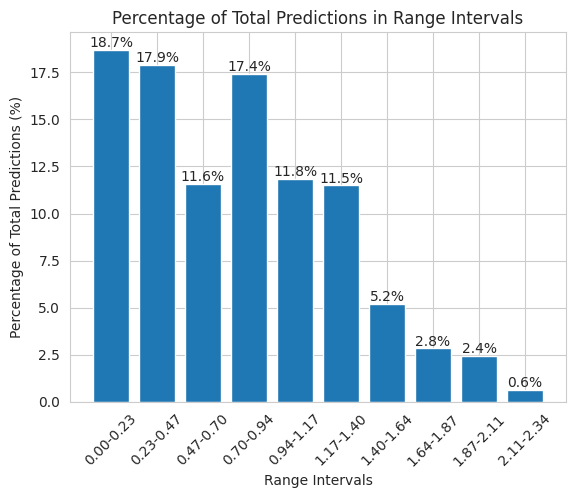

In [218]:
import matplotlib.pyplot as plt

# Get the minimum and maximum differences
min_diff = min(diffs.keys())
max_diff = max(diffs.keys())

# Create range intervals
interval_size = (max_diff - min_diff) / 10
intervals = [(min_diff + i * interval_size, min_diff +
              (i + 1) * interval_size) for i in range(10)]

# Count the number of predictions in each interval
counts = [0] * 10
for diff, _ in diffs.values():
    for i, (start, end) in enumerate(intervals):
        if start <= diff < end:
            counts[i] += 1
            break

# Calculate total number of predictions
total_predictions = sum(counts)

# Calculate percentage for each interval
percentages = [(count / total_predictions) * 100 for count in counts]

# Plot the bar plot
bars = plt.bar(range(10), percentages)
plt.xlabel('Range Intervals')
plt.ylabel('Percentage of Total Predictions (%)')
plt.xticks(
    range(10), [f'{start:.2f}-{end:.2f}' for start, end in intervals], rotation=45)
plt.title('Percentage of Total Predictions in Range Intervals')

# Add percentage above each bar
for bar, percentage in zip(bars, percentages):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
             f'{percentage:.1f}%', ha='center', va='bottom')

plt.show()

### Box plot
A box plot (or box-and-whisker plot) is a standarized way of displaying the distribution of data based of a five-number summary: minimum, first quartile (Q1), median/second quartile (Q2), third quartile (Q3) and maximum.

1. **Minimum:** The lowest data point excluding any outliers.
2. **First Quartile (Q1):** The median of the lower half of the dataset. This is the point at which 25% of the data lies below it.
3. **Median/Second Quartile (Q2):** The middle value of the dataset which divides the data into two halves. Half of the data points are above the median, and half are below.
4. **Third Quartile (Q3):** The median of the upper half of the dataset. About 75% of the data lies below this value.
5. **Maximum:** The highest data point exlucding any outliers.

Box plots include "whiskers" which extend from the quartiles to the highest and lowest values within 1.5 times the interquartile range (IQR) from the first and third quartiles. Points outside this range are considered outliers and are often indicated with dots, small circles, or stars.

The box itself contains the middle 50% of the data, highlighting the central tendency and spread of the values, while the whiskers show the range. This makes box plots very useful for comparing distributions and spotting outliers in data across different categories.

In [219]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

spei_vals = [value[0] for value in diffs.values()]
predicted_spei_vals = [value[1] for value in diffs.values()]

In [220]:
data = {"Predicted SPEI": predicted_spei_vals}
df = pd.DataFrame(data)
df.head()

,Predicted SPEI
0,-0.356331
1,-0.421876
2,-0.324207
3,-0.089697
4,0.029993


In [221]:
vals, names, xs = [], [], []
for i, col in enumerate(df.columns):
    vals.append(df[col].values)
    names.append(col)
    # adds jitter to the data points - can be adjusted
    xs.append(np.random.normal(i + 1, 0.04, df[col].values.shape[0]))

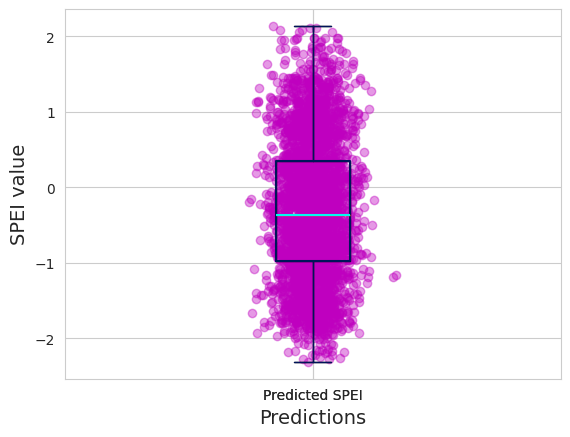

In [222]:
plt.boxplot(vals, labels=names)
palette = ['m','g', 'b', 'y']
for x, val, c in zip(xs, vals, palette):
    plt.scatter(x, val, alpha=0.4, color=c)

##### Set style options here #####
sns.set_style("whitegrid")  # "white","dark","darkgrid","ticks"
boxprops = dict(linestyle='-', linewidth=1.5, color='#00145A')
flierprops = dict(marker='o', markersize=1,
                  linestyle='none')
whiskerprops = dict(color='#00145A')
capprops = dict(color='#00145A')
medianprops = dict(linewidth=1.5, linestyle='-', color='#01FBEE')

plt.boxplot(vals, labels=names, notch=False, boxprops=boxprops, whiskerprops=whiskerprops,
            capprops=capprops, flierprops=flierprops, medianprops=medianprops, showmeans=False)

plt.xlabel("Predictions", fontweight='normal', fontsize=14)
plt.ylabel("SPEI value", fontweight='normal', fontsize=14)
# sns.despine(bottom=True)  # removes right and top axis lines
# plt.axhline(y=0, color='#ff3300', linestyle='--',
#             linewidth=1, label='Threshold Value')
# plt.legend(bbox_to_anchor=(0.31, 1.06), loc=2, borderaxespad=0.,
#            framealpha=1, facecolor='white', frameon=True)
    
plt.show()

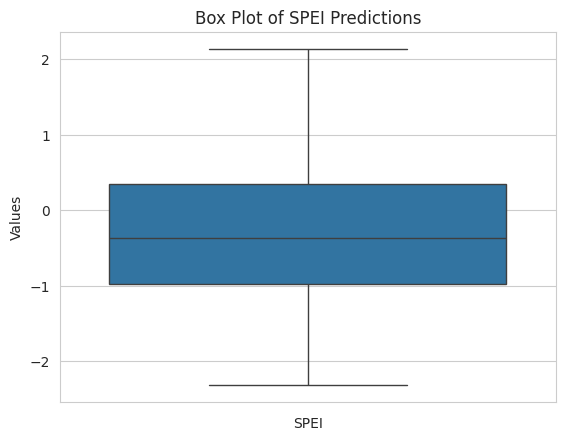

In [223]:
sns.boxplot(data=df['Predicted SPEI'])
plt.title('Box Plot of SPEI Predictions')
plt.xlabel('SPEI')
plt.ylabel('Values')
plt.show()

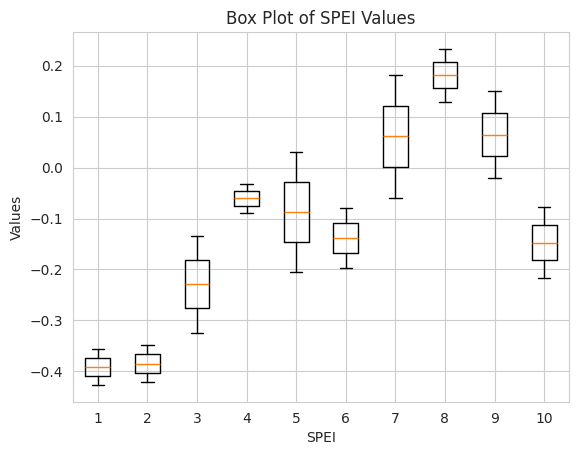

In [224]:
import matplotlib.pyplot as plt

spei_vals = [value for value in diffs.values()]
spei_vals = spei_vals[:10]

# Create a figure and axis
fig, ax = plt.subplots()

# Create the box plot
ax.boxplot(spei_vals)

# Set the title and labels
ax.set_title('Box Plot of SPEI Values')
ax.set_xlabel('SPEI')
ax.set_ylabel('Values')

# Show the plot
plt.show()
